# figure out how often a given location is impacted by storms
# this will determine what a good number of days is in the calculation of the anomaly
# (subtracting avg over XX days preceding a storm's passage)
# approach: for each storm 1997-2018 (all positions at noon), store time information as "days since Jan 1, 1997"
# -> then I can easily get the temporal separation of storm passings for each location
# "storm passing": I here include the area within 1000km of the storm center

In [1]:
import os
from tqdm import tqdm
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset, MFDataset
import numba as nb
import time as timing
from numba import njit 
from math import sin, cos, sqrt, atan2, radians
from geopy.distance import distance
import seawater as sw
import datetime
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
from cartopy.util import add_cyclic_point
import matplotlib.path as mpath
import matplotlib.ticker as mticker

In [2]:
#---
# general settings
#---

savepath_plots     = '/global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/storm_passing_freq/'
# check existence of paths
if not os.path.exists(savepath_plots):
    print ('Created '+savepath_plots)
    os.makedirs(savepath_plots)
    

In [3]:
#---
# load data
#---

var = 'totChl' 

path1 = '/global/cfs/cdirs/m4003/cnissen/CESM_totChl_anomalies/'
file1 = 'Anomalies_within_1000km_of_storm_center_'+var+'_JRA_grid_1997-01-01_TEST.nc'

ff    = xr.open_dataset(path1+file1)
data  = ff[var+'_storm'].values # abs chlorophyll field
lat   = ff['lat'].values
lon   = ff['lon'].values
index_storm = ff['index_storm'].values
year_storm  = ff['year_storm'].values
month_storm = ff['month_storm'].values
day_storm   = ff['day_storm'].values
ff.close()

print(data.shape)
print(lat.shape,lon.shape)
print(index_storm.shape,year_storm.shape,month_storm.shape,day_storm.shape)


(1066, 320, 640)
(320,) (640,)
(1066,) (1066,) (1066,) (1066,)


Number of storms for current year: 204
All indices of current storm: [111 113 116 117 120 124 128 136 140]
Max. number of days that the storm is in a given location: 6.0


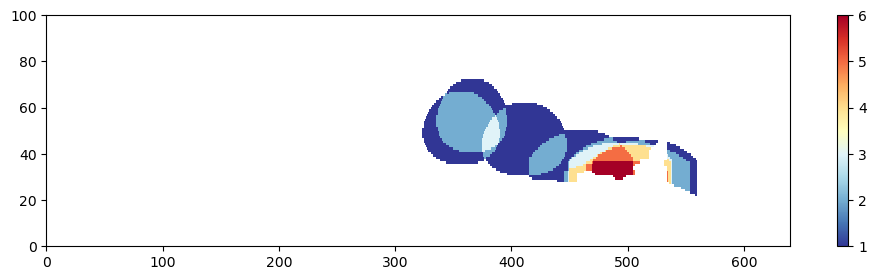

In [4]:
#---
# plot positions at noon of any given storm -> check how much they overlap in space
#---

print('Number of storms for current year:',int(np.max(index_storm)))

nn = 20 # storm ID

ind = np.where(index_storm==nn)[0]
print('All indices of current storm:',ind)

data_plot = np.zeros([len(lat),len(lon)])
for ii in range(0,ind.shape[0]):
    aux = data[ind[ii],:,:]
    data_plot[~np.isnan(aux)] = data_plot[~np.isnan(aux)] + 1
    del aux
    
data_plot[data_plot==0] = np.nan
print('Max. number of days that the storm is in a given location:',np.nanmax(data_plot))

cmap1 = plt.cm.RdYlBu_r
v1,v2 = 1,np.nanmax(data_plot) #ind.shape[0]

fig  = plt.figure(figsize=(12,3))
plt.pcolor(data_plot[0:100,:],cmap=cmap1,vmin=v1,vmax=v2)#,vmin=-10,vmax=10)
plt.colorbar()
plt.show()


In [5]:
%%time
#---
# for each storm, mark the area of imprint with the respective day of the time series
#---

years = np.arange(1997,2018+1,1)

save_netcdf = False
    
# where is the data?
#path1 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_final/diat_light_lim_surf_anomalies/' #'/global/cfs/cdirs/m4003/cnissen/CESM_totChl_anomalies/'
path1 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_final/MLD_anomalies/' #'/global/cfs/cdirs/m4003/cnissen/CESM_totChl_anomalies/'

test_plot = False

# only do this once. Load files from folder once they exist
if save_netcdf: 
    # later: add loop over all years here! -> store "data_storm_passings" of each year as netcdf 
    for yy in range(0,len(years)): 
        print(years[yy],'...')

        #file1 = 'Anomalies_within_1000km_of_storm_center_totChl_JRA_grid_'+str(years[yy])+'-01-01_TEST.nc'
        #file1 = 'Anomalies_within_1000km_of_storm_center_diat_light_lim_surf_JRA_grid_'+str(years[yy])+'-01-01_all_at_noon.nc'
        file1 = 'Anomalies_within_1000km_of_storm_center_MLD_JRA_grid_'+str(years[yy])+'-01-01_all_at_noon.nc'
        
        ff    = xr.open_dataset(path1+file1)
        #data  = ff['diat_light_lim_surf_storm'].values # abs chlorophyll field
        data  = ff['MLD_storm'].values # abs chlorophyll field
        lat   = ff['lat'].values
        lon   = ff['lon'].values
        index_storm = ff['index_storm'].values
        year_storm  = ff['year_storm'].values
        month_storm = ff['month_storm'].values
        day_storm   = ff['day_storm'].values
        ff.close()

        print('min/max index_storm:',np.nanmin(index_storm),np.nanmax(index_storm)) # indices go up from 1997-2018
        range_index_storms = range(int(np.nanmin(index_storm)),int(np.nanmax(index_storm)))

        num_storms = int(np.max(index_storm)-np.min(index_storm)+1)
        print('Number of storms for current year:',num_storms)

        data_storm_passings = np.nan*np.ones([num_storms,len(lat),len(lon)])
        counter = 0 # to put the resulting field into the right index of data_storm_passings
        for nn in tqdm(range_index_storms): # storm IDs of current year

            ind = np.where(index_storm==nn)[0] #nn+1)[0]
            aux_year  = year_storm[ind]
            aux_month = month_storm[ind]
            aux_day   = day_storm[ind]

            # convert date of each time step for current storm into "days since Jan 1 1997"
            days_since = np.zeros(len(aux_year))
            for tt in range(0,len(aux_year)):
                d = datetime.datetime(aux_year[tt], aux_month[tt], aux_day[tt])
                date = d.date()
                #print('date:',date)
                day_of_year = date.timetuple().tm_yday
                if aux_year[tt] in [2000,2004,2008,2012,2016]: # calendar in CESM does not have leap years
                    day_of_year = day_of_year-1 
                #print('day_of_year:',day_of_year)
                days_since[tt] = int(day_of_year+(aux_year[tt]-1997)*365)
                #print('day_since_Jan1_1997:',days_since[tt])

            # loop over the time steps of the current storm: collect the area of imprint
            data_plot = np.zeros([len(lat),len(lon)])
            for ii in range(0,ind.shape[0]):
                aux = data[ind[ii],:,:]
                # for each time step of the current storm, mark time_stamp "days since Jan 1 1997" on the map
                data_plot[~np.isnan(aux)] = int(days_since[ii]) #ii+1 
                del aux
            data_plot[data_plot==0] = np.nan

            if test_plot:
                cmap1 = plt.cm.RdYlBu_r
                v1,v2 = np.min(days_since),np.max(days_since) #1,ind.shape[0]
                fig  = plt.figure(figsize=(12,3))
                plt.pcolor(data_plot[0:100,:],cmap=cmap1,vmin=v1,vmax=v2)#,vmin=-10,vmax=10)
                plt.colorbar()
                plt.show()
                del cmap1,v1,v2

            data_storm_passings[counter,:,:] = data_plot
            counter = counter+1
            del data_plot,ind,aux_year,aux_month,aux_day

        print('min/max data_storm_passings:',np.nanmin(data_storm_passings),np.nanmax(data_storm_passings))
        #----
        # save as netcdf
        #----
        if save_netcdf:
            savepath = path1
            fv = -999
            dist_threshold = 1000
            netcdf_name = 'Storm_imprint_within_'+str(dist_threshold)+\
                                'km_of_storm_center_JRA_grid_'+str(years[yy])+'-01-01_TEST.nc'
            if not os.path.exists(savepath+netcdf_name):
                print('Create file '+savepath+netcdf_name)
                w_nc_fid = Dataset(savepath+netcdf_name, 'w', format='NETCDF4_CLASSIC')
                w_nc_fid.contact     = 'Cara Nissen, cara.nissen@colorado.edu'
                w_nc_fid.source_data = path1+file1
                w_nc_fid.script      = '/global/homes/c/cnissen/scripts/plot_CESM_days_between_storms.ipynb'
                # create dimension & variable
                w_nc_fid.createDimension('lon', len(lon)) 
                w_nc_fid.createDimension('lat', len(lat)) 
                w_nc_fid.createDimension('num_storms', num_storms) 

                w_nc_var1 = w_nc_fid.createVariable('storm_passings', 'f4',('num_storms','lat','lon'),fill_value=fv)
                w_nc_var1.long_name = 'Area of imprint of each storm (all storm time steps at noon)'
                #w_nc_var1.units = 'days' #'day since Jan 1, 1997'
                w_nc_var1.note = 'days since 1997-01-01 00:00:00' #'day since Jan 1, 1997'

                w_nc_var1 = w_nc_fid.createVariable('lat', 'f4',('lat'),fill_value=fv)
                w_nc_var1.description = 'Latitude'
                w_nc_var1.units = 'deg N'
                w_nc_var1 = w_nc_fid.createVariable('lon', 'f4',('lon'),fill_value=fv)
                w_nc_var1.description = 'Longitude (-180:180)'
                w_nc_var1.units = 'deg E'

                # write lat/lon to file
                w_nc_fid.variables['lat'][:] = lat
                w_nc_fid.variables['lon'][:] = lon
                w_nc_fid.close()

            # write data_storm_passings into file
            data_storm_passings[np.isnan(data_storm_passings)] = fv
            w_nc_fid = Dataset(savepath+netcdf_name, 'r+', format='NETCDF4_CLASSIC') 
            w_nc_fid.variables['storm_passings'][:,:,:] = data_storm_passings
            w_nc_fid.close()

        del num_storms,data,lat,lon,index_storm,year_storm,month_storm,day_storm


CPU times: user 23 µs, sys: 26 µs, total: 49 µs
Wall time: 55.8 µs


In [6]:
#---
# load all the resulting fields and figure out the average time between that location being in a storm
#---

years = np.arange(1997,2018+1,1) 

vari = 'MLD' # diat_light_lim_surf or totChl or D

# where is the data?
#path1 = '/global/cfs/cdirs/m4003/cnissen/CESM_totChl_anomalies/'
path1 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_final/'+vari+'_anomalies/' 

for yy in tqdm(range(0,len(years))): 
    
    file1 = 'Storm_imprint_within_1000km_of_storm_center_JRA_grid_'+str(years[yy])+'-01-01_TEST.nc'

    ff    = xr.open_dataset(path1+file1)
    data  = ff['storm_passings'].values 
    lat   = ff['lat'].values
    lon   = ff['lon'].values
    ff.close()
    
    if yy==0: 
        data_all = data
    else:
        data_all = np.concatenate((data_all,data))
    #del data

print(data_all.shape)
print('min/max:',np.nanmin(data_all),np.nanmax(data_all))


100%|██████████| 22/22 [01:14<00:00,  3.41s/it]


(9732, 320, 640)
min/max: 1.0 8030.0


In [7]:
print(data[0,:,:])

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [8]:
#---
# for each location, collect days between storm passings, store MEDIAN in array
#---

time_between_passings = np.zeros([data_all.shape[1],data_all.shape[2]])
for mm in tqdm(range(0,data_all.shape[1])):
    for nn in range(0,data_all.shape[2]):
        aux = data_all[:,mm,nn]
        ind1 = np.where(~np.isnan(aux))[0]
        if len(ind1)>0:
            aux = aux[ind1] # reduce to the days when a storm passes
            aux = np.diff(aux) # get difference between any two passings
            time_between_passings[mm,nn] = np.median(aux)
            del aux,ind1
            
time_between_passings = np.ma.masked_where(time_between_passings==0,time_between_passings)
print('min/max time between passings:',np.nanmin(time_between_passings),np.nanmax(time_between_passings))


 32%|███▏      | 102/320 [00:08<00:15, 13.97it/s]/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/c/cnissen/.conda/envs/myenv/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 320/320 [00:21<00:00, 15.22it/s]

min/max time between passings: 4.0 6721.0


In [9]:

ind1 = np.where(~np.isnan(data_all[:,100,100]))[0]
print(ind1)
aux = data_all[ind1,100,100]
print(np.diff(aux))


[ 110  375  528  568  856 1181 1239 3375 3919 4131 4310 4315 4539 4577
 5346 5371 5574 5689 5777 6679 6971 7370 8084 8182 8195 8324 8749 8942
 9269 9535 9564 9617]
[ 218.  130.   37.  233.  260.   51. 1800.  457.  180.  150.    3.  189.
   28.  646.   19.  174.   96.   66.  722.  220.  320.  573.   76.    8.
  112.  349.  159.  260.  217.   24.   42.]


In [10]:
#----
# load sea ice
#----

path_ice = '/global/cfs/cdirs/m4003/cnissen/CESM_sic/'

data_ice = np.nan*np.ones([len(years),320,640])
data_ice_max = np.nan*np.ones([len(years),320,640])
for yy in tqdm(range(0,len(years))): 
    
    file1    = 'ECOSYS_IFRAC_2_JRA_grid_'+str(years[yy])+'-01-01.nc' 
    ff       = xr.open_dataset(path_ice+file1)
    data_ice[yy,:,:] = ff['ECOSYS_IFRAC_2'].mean(axis=0).values
    data_ice_max[yy,:,:] = ff['ECOSYS_IFRAC_2'].max(axis=0).values # sea ice maximum over a year at each location
    ff.close()
    
    del file1
    
# average over all years
data_ice     = np.nanmean(data_ice,axis=0)
data_ice_max = np.nanmean(data_ice_max,axis=0)
print(data_ice.shape)
print(data_ice_max.shape)


100%|██████████| 22/22 [00:54<00:00,  2.49s/it]

(320, 640)
(320, 640)



/tmp/ipykernel_95414/641076924.py:20: RuntimeWarning: Mean of empty slice
  data_ice     = np.nanmean(data_ice,axis=0)
/tmp/ipykernel_95414/641076924.py:21: RuntimeWarning: Mean of empty slice
  data_ice_max = np.nanmean(data_ice_max,axis=0)


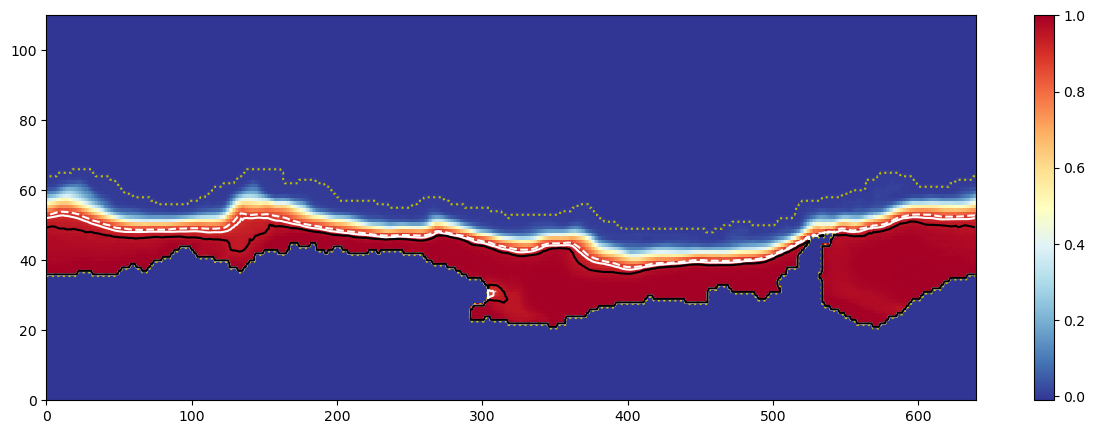

In [11]:
#---
# simple plot: sea ice 
#---

data_plot = np.copy(data_ice_max)
data_plot[np.isnan(data_plot)] = -1

cmap1 = plt.cm.RdYlBu_r
v1,v2 = -0.01,1

fig  = plt.figure(figsize=(15,5))
plt.pcolor(data_plot[0:110,:],cmap=cmap1,vmin=v1,vmax=v2)#,vmin=-10,vmax=10)
plt.colorbar()
plt.contour(data_plot[0:110,:],levels=[0,0.85,0.9,0.95],colors=['y','w','w','k'],linestyles=[':','--','-','-'])
plt.show()


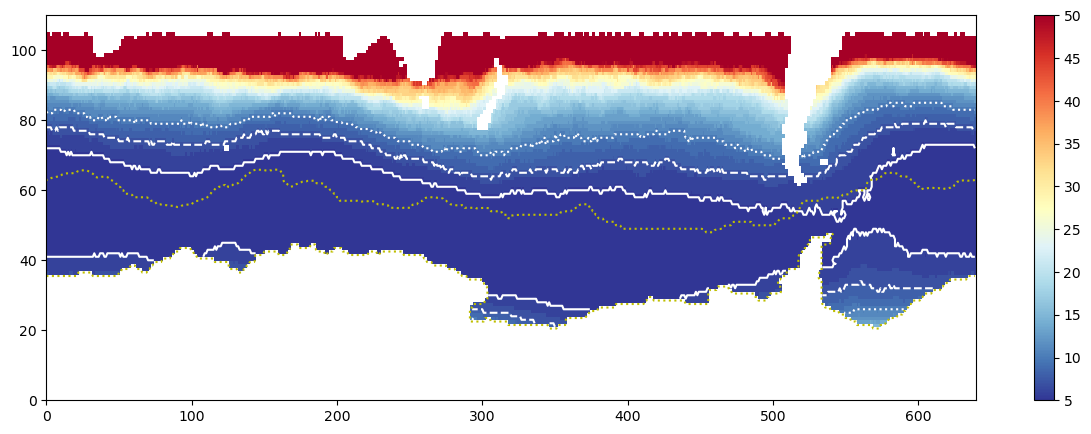

In [12]:
#---
# simple plot: days between storms
#---

data_plot = np.copy(data_ice_max)
data_plot[np.isnan(data_plot)] = -1

cmap1 = plt.cm.RdYlBu_r
v1,v2 = 5,50

fig  = plt.figure(figsize=(15,5))
plt.pcolor(time_between_passings[0:110,:],cmap=cmap1,vmin=v1,vmax=v2)#,vmin=-10,vmax=10)
plt.colorbar()
plt.contour(time_between_passings[0:110,:],levels=[5,7,10],colors=['w','w','w'],linestyles=['-','--',':'])
plt.contour(data_plot[0:110,:],levels=[0.0001],colors=['y','w','w','k'],linestyles=[':','--','-','-'])
plt.show()


[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 11.0
 9.483333333333333 9.022727272727273 8.331896551724139 8.063492063492063
 7.4714285714285715 6.919871794871795 6.51595744680851 6.186936936936937
 5.993534482758621 5.948473282442748 5.75 5.416083916083916
 5.2311643835616435 5.179245283018868 5.202956989247312 5.1091370558375635
 5.085280373831775 5.054932735426009 5.051063829787234 4.911224489795918
 4.781481481481482 4.729026845637584 4.710483870967742 4.689297124600639
 4.676517571884984 4.651419558359621 4.6046875 4.58203125 4.584375
 4.5328125 4.49453125 4.5265625 4.52734375 4.6 4.66640625 4.7140625
 4.803125 4.921875 5.06796875 5.203616352201258 5.3317460317460315
 5.473015873015873 5.685509554140127 5.912698412698413 6.210191082802548
 6.430064308681672 6.639423076923077 6.9 7.122204472843451
 7.467845659163987 7.899193548387097 8.191318327974276 8.682475884244372
 9.128205128205128 9.614951768488746 10.145292207792208 10.785714285714286
 11.458469055374593 12

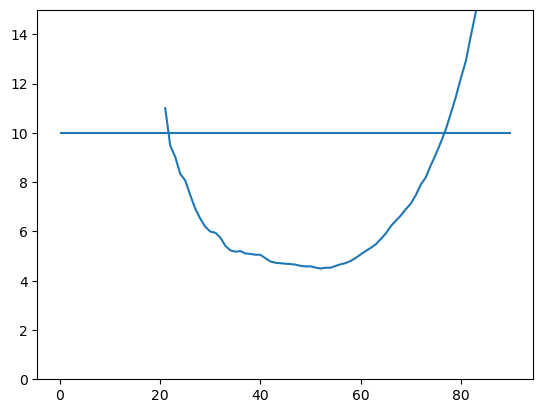

In [13]:

aux = np.nanmean(time_between_passings[0:90,:],axis=1)
print(aux)
print(lat[75:80],aux[75:80])

plt.hlines(10,0,90)
plt.plot(aux)
plt.ylim((0,15))
plt.show()



In [14]:
#----
# FUNCTIONS
#----

# transform longitude (e.g., go from -179.5:179.5 to 0.5:359.5)
def transform_lon_coord(data):
    # change lon coordinate in 2D array from 0-360 to -180:180
    # for 2D arrays: assume lon coordinate to be the 2nd dimension  
    # for 3D arrays: assume lon coordinate to be the 3rd dimension 
    if len(data.shape)==2:
        data_transformed          = np.empty_like(data)
        num_lon = int(data.shape[1]/2)
        data_transformed[:,0:num_lon] = data[:,num_lon:]
        data_transformed[:,num_lon:]  = data[:,0:num_lon] 
        #data_transformed[:,0:180] = data[:,180:]
        #data_transformed[:,180:]  = data[:,0:180] 
    elif len(data.shape)==3:
        data_transformed          = np.empty_like(data)
        try:
            data_transformed[:,:,0:180] = data[:,:,180:]
            data_transformed[:,:,180:]  = data[:,:,0:180]
        except:
            data_transformed[:,0:180,:] = data[:,180:,:]
            data_transformed[:,180:,:]  = data[:,0:180,:] 
    elif len(data.shape)==4:
        data_transformed          = np.empty_like(data)
        data_transformed[:,0:180,:,:] = data[:,180:,:,:]
        data_transformed[:,180:,:,:]  = data[:,0:180,:,:] 
    elif len(data.shape)==1:
        data_transformed          = np.empty_like(data)
        num_lon = int(data.shape[0]/2)
        data_transformed[0:num_lon] = data[num_lon:]
        data_transformed[num_lon:]  = data[0:num_lon] 
        #data_transformed[0:180] = data[180:]
        #data_transformed[180:]  = data[0:180]
    return data_transformed


4.0 6721.0


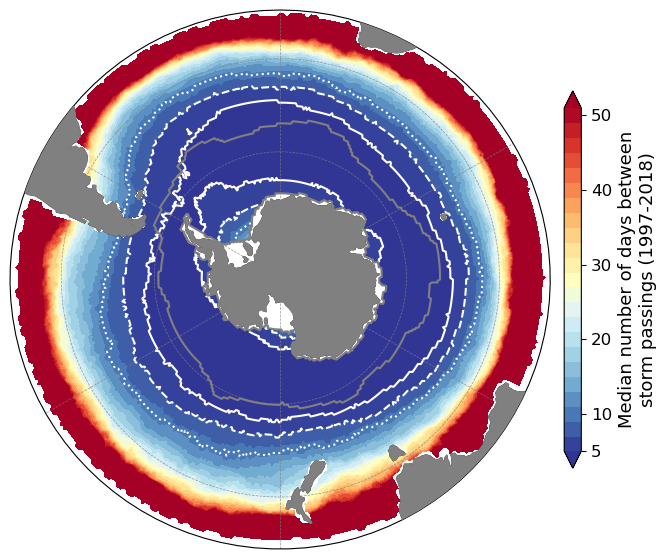

In [15]:
#----
# with projection 
#----

fs = 12
lon_tf             = np.copy(lon)
lon_tf[lon_tf>180] = lon_tf[lon_tf>180]-360
lon_tf             = transform_lon_coord(lon_tf)

data_plot = transform_lon_coord(time_between_passings)
data_plot_ice = transform_lon_coord(data_ice_max)

# add cyclic point
data_plot_b = np.zeros([320,641])
data_plot_b[:,0:640] = data_plot
data_plot_b[:,-1] = data_plot[:,0] 
data_plot_b = np.ma.masked_where(data_plot_b==0,data_plot_b)
data_plot = data_plot_b
del data_plot_b

# add cyclic point, sea ice
data_plot_b = np.zeros([320,641])
data_plot_b[:,0:640] = data_plot_ice
data_plot_b[:,-1] = data_plot_ice[:,0] 
data_plot_b = np.ma.masked_where(data_plot_b==0,data_plot_b)
data_plot_ice = data_plot_b
del data_plot_b
data_plot_ice[np.isnan(data_plot_ice)] = -1 # to make zero contour show up correctly

# add cyclic point
lon_tf_b        = np.zeros([641])
lon_tf_b[0:640] = lon_tf
lon_tf_b[-1]    = lon_tf[0] 
lon_tf          = lon_tf_b
del lon_tf_b

lon_tf[0] = -1*lon_tf[0]
lon2,lat2 = np.meshgrid(lon_tf,lat)


save_plots = False
display_plots = True

fig = plt.figure(figsize=(18,7)) # x, y
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #PlateCarree())
#ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) 
ax.set_extent([-179, 179, -90, -30], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,facecolor='grey',zorder=100)
ax.coastlines()

# permanently circular.a
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#mm=ax.pcolor(lon2[0:110,:],lat2[0:110,:],data_plot[0:110,:],cmap=cmap1,vmin=v1,vmax=v2,transform=ccrs.PlateCarree(),zorder=30)
lev1 = np.arange(5,50+2,2)
cticks1 = [5,10,20,30,40,50]
print(np.nanmin(data_plot[0:110,:]),np.nanmax(data_plot[0:110,:]))
mm=ax.contourf(lon2[0:110,:],lat2[0:110,:],data_plot[0:110,:],cmap=cmap1,levels=lev1,extend='both',\
               transform=ccrs.PlateCarree())#,zorder=100)
cbar = plt.colorbar(mm,ax=ax,orientation='vertical',fraction=0.075, pad=0.01,shrink=0.7,ticks=cticks1)
cbar.set_label('Median number of days between\nstorm passings (1997-2018)',fontsize=fs+1) #clabel_string
cbar.ax.tick_params(labelsize=fs)
#cbar.ax.set_xticklabels(cticks_label)

gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=.5,\
                    color='grey', alpha=0.8,linestyle='--')#,xlabels_bottom=True)
gl.top_labels = True
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels=True
#gl.xlines = True
gl.xlocator = mticker.FixedLocator([-180,-120,-60,0,60,120]) 
gl.ylocator = mticker.FixedLocator([-60,-40])
#gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.rotate_labels = False

# add some contour lines
#ax.contour(lon2[0:110,:],lat2[0:110,:],data_plot[0:110,:],levels=[7],\
#           colors=['w','w','w'],linestyles=['-','--',':'],transform=ccrs.PlateCarree())
cs=ax.contour(lon2[0:110,:],lat2[0:110,:],data_plot[0:110,:],levels=[5,7,10],\
           colors=['w','w','w'],linestyles=['-','--',':'],transform=ccrs.PlateCarree())

# add sea ice contour
cs=ax.contour(lon2[0:110,:],lat2[0:110,:],data_plot_ice[0:110,:],levels=[0],\
           colors=['grey','w','w'],linestyles=['-','--',':'],transform=ccrs.PlateCarree())

#plt.contour(data_ice_max[0:110,:],levels=[0.0001,0.85,0.9,0.95],colors=['y','w','w','k'],linestyles=[':','--','-','-'])


#def path_length(path):
#    v = path.vertices
#    dv = np.diff(v, axis=0)
#    return np.sum(np.sqrt(np.sum(dv**2, axis=-1)))
## remain the longest path and remove all others
#deleted_path = []
#for c in cs.collections:
#    paths = c.get_paths()
#    if len(paths) > 1:
#        paths.sort(key=path_length, reverse=True)
#        for p in paths[1:]:
#            deleted_path.append((c, p))
#        del paths[1:]
## create labels
#r = ax.clabel(cs, [5,7,10], inline=True, fontsize=12, fmt='%1.0f')
## restore all removed paths
#for c, p in deleted_path:
#    c.get_paths().append(p)
    
#ax.clabel(cs, [5,7,10], inline=True, inline_spacing = 20, fmt='%1.0f')

if save_plots:
    dpicnt = 200
    filename = 'Days_between_passing_of_storms_median_1997_2018.png'
    print(savepath_plots+filename)   
    plt.savefig(savepath_plots+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
if display_plots:
    plt.show()
else:
    plt.close(fig)


4.0 6721.0
/global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/storm_passing_freq/Days_between_passing_of_storms_median_1997_2018_40S.png


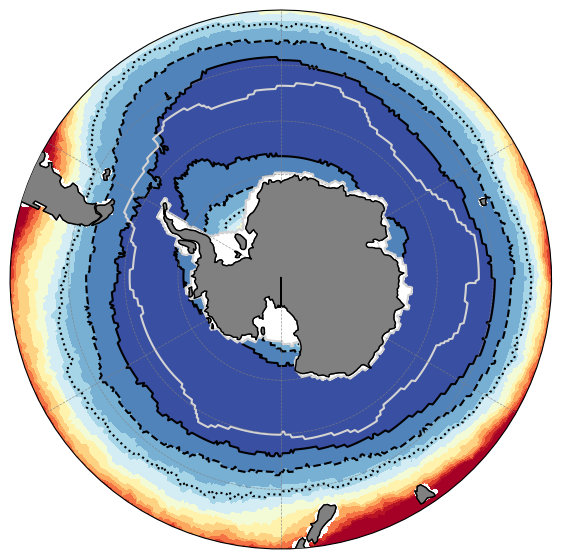

/global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/storm_passing_freq/Days_between_passing_of_storms_median_1997_2018_40S_COLORBAR.png


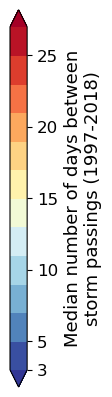

/global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/storm_passing_freq/Days_between_passing_of_storms_median_1997_2018_40S_COLORBAR.eps


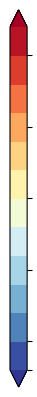

In [16]:
#----
# with projection 
#----

fs = 12
lon_tf             = np.copy(lon)
lon_tf[lon_tf>180] = lon_tf[lon_tf>180]-360
lon_tf             = transform_lon_coord(lon_tf)

data_plot = transform_lon_coord(time_between_passings)
data_plot_ice = transform_lon_coord(data_ice_max)

# add cyclic point
data_plot_b = np.zeros([320,641])
data_plot_b[:,0:640] = data_plot
data_plot_b[:,-1] = data_plot[:,0] 
data_plot_b = np.ma.masked_where(data_plot_b==0,data_plot_b)
data_plot = data_plot_b
del data_plot_b

# add cyclic point, sea ice
data_plot_b = np.zeros([320,641])
data_plot_b[:,0:640] = data_plot_ice
data_plot_b[:,-1] = data_plot_ice[:,0] 
data_plot_b = np.ma.masked_where(data_plot_b==0,data_plot_b)
data_plot_ice = data_plot_b
del data_plot_b
data_plot_ice[np.isnan(data_plot_ice)] = -1 # to make zero contour show up correctly

# add cyclic point
lon_tf_b        = np.zeros([641])
lon_tf_b[0:640] = lon_tf
lon_tf_b[-1]    = lon_tf[0] 
lon_tf          = lon_tf_b
del lon_tf_b

lon_tf[0] = -1*lon_tf[0]
lon2,lat2 = np.meshgrid(lon_tf,lat)


save_plots = True
display_plots = True
plot_eps = True

fig = plt.figure(figsize=(18,7)) # x, y
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #PlateCarree())
#ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) 
ax.set_extent([-179, 179, -90, -40], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,facecolor='grey',edgecolor='k',zorder=100)
ax.coastlines()

# permanently circular.a
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#mm=ax.pcolor(lon2[0:110,:],lat2[0:110,:],data_plot[0:110,:],cmap=cmap1,vmin=v1,vmax=v2,transform=ccrs.PlateCarree(),zorder=30)
lev1 = np.arange(3,27+2,2)
cticks1 = [3,5,10,15,20,25]#,40,50]
print(np.nanmin(data_plot[0:110,:]),np.nanmax(data_plot[0:110,:]))
mm=ax.contourf(lon2[0:110,:],lat2[0:110,:],data_plot[0:110,:],cmap=cmap1,levels=lev1,extend='both',\
               transform=ccrs.PlateCarree())#,zorder=100)
#cbar = plt.colorbar(mm,ax=ax,orientation='vertical',fraction=0.075, pad=0.01,shrink=0.7,ticks=cticks1)
#cbar.set_label('Median number of days between\nstorm passings (1997-2018)',fontsize=fs+1) #clabel_string
#cbar.ax.tick_params(labelsize=fs)
##cbar.ax.set_xticklabels(cticks_label)

gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=.5,\
                    color='grey', alpha=0.8,linestyle='--')#,xlabels_bottom=True)
gl.top_labels = True
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels=True
#gl.xlines = True
gl.xlocator = mticker.FixedLocator([-180,-120,-60,0,60,120]) 
gl.ylocator = mticker.FixedLocator([-70,-60,-50])
#gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.rotate_labels = False

# add some contour lines
#ax.contour(lon2[0:110,:],lat2[0:110,:],data_plot[0:110,:],levels=[7],\
#           colors=['w','w','w'],linestyles=['-','--',':'],transform=ccrs.PlateCarree())
cs=ax.contour(lon2[0:110,:],lat2[0:110,:],data_plot[0:110,:],levels=[5,7,10],\
           colors=['k','k','k'],linestyles=['-','--',':'],transform=ccrs.PlateCarree())

# add sea ice contour
cs=ax.contour(lon2[0:110,:],lat2[0:110,:],data_plot_ice[0:110,:],levels=[0],\
           colors=['lightgrey','w','w'],linestyles=['-','--',':'],transform=ccrs.PlateCarree())

if save_plots:
    dpicnt = 200
    filename = 'Days_between_passing_of_storms_median_1997_2018_40S.png'
    print(savepath_plots+filename)   
    plt.savefig(savepath_plots+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
if display_plots:
    plt.show()
else:
    plt.close(fig)
    
#----
# colorbar only
#----
lev1 = np.arange(3,27+2,2)
cticks1 = [3,5,10,15,20,25]
ctick_label = ['','','','','','']

fig = plt.figure(figsize=(18,7)) # x, y
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #PlateCarree())
mm=ax.contourf(lon2[0:110,:],lat2[0:110,:],data_plot[0:110,:],cmap=cmap1,levels=lev1,extend='both',\
               transform=ccrs.PlateCarree())#,zorder=100)
plt.gca().set_visible(False)
cbar = plt.colorbar(mm,ax=ax,orientation='vertical',fraction=0.075, pad=0.01,shrink=0.7,ticks=cticks1)
cbar.set_label('Median number of days between\nstorm passings (1997-2018)',fontsize=fs+1) #clabel_string
cbar.ax.tick_params(labelsize=fs)
#cbar.ax.set_xticklabels(cticks_label)
if save_plots:
    dpicnt = 200
    filename = 'Days_between_passing_of_storms_median_1997_2018_40S_COLORBAR.png'
    print(savepath_plots+filename)   
    plt.savefig(savepath_plots+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
if display_plots:
    plt.show()
else:
    plt.close(fig)
    
if plot_eps:
    fig = plt.figure(figsize=(18,7)) # x, y
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo()) #PlateCarree())
    mm=ax.contourf(lon2[0:110,:],lat2[0:110,:],data_plot[0:110,:],cmap=cmap1,levels=lev1,extend='both',\
                   transform=ccrs.PlateCarree())#,zorder=100)
    plt.gca().set_visible(False)
    cbar = plt.colorbar(mm,ax=ax,orientation='vertical',fraction=0.075, pad=0.01,shrink=0.7,ticks=cticks1)
    cbar.ax.tick_params(labelsize=fs)
    cbar.ax.set_yticklabels(ctick_label)
    if save_plots:
        dpicnt = 200
        filename = 'Days_between_passing_of_storms_median_1997_2018_40S_COLORBAR.eps'
        print(savepath_plots+filename)   
        plt.savefig(savepath_plots+filename,dpi = dpicnt, bbox_inches='tight',format='eps')#,transparent=True)
    if display_plots:
        plt.show()
    else:
        plt.close(fig)


In [17]:
print(savepath_plots)

/global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/storm_passing_freq/
